In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import glob
import sys

from math import *
import pickle

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable

from IPython import display
import time

import copy

def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x).cuda(), requires_grad = False)

In [2]:
class Attention(nn.Module):
    def __init__(self, Nfield, Nhead, Nkey, Nval):
        super(Attention,self).__init__()
        
        self.field_to_key = nn.Conv1d(Nfield, Nkey, 1)
        self.field_to_val = nn.Conv1d(Nfield, Nval, 1)        
        self.head_to_key = nn.Conv1d(Nhead, Nkey, 1)
        
        self.nkey = Nkey
        self.nval = Nval
        
    def forward(self, field, value, heads):
        s = field.size()
        fkeys = self.field_to_key(field)
        fvals = self.field_to_val(value)
        
        hkeys = self.head_to_key(heads) # Batch * Keys * Heads
        
        z = torch.bmm(fkeys.transpose(1,2), hkeys)/sqrt(self.nkey)
        w = torch.exp(torch.clamp(z,-30,30)) # Batch * (X*Y) * Heads
        w = w/(torch.sum(w,1,keepdim=True) + 1e-16)
        
        y = torch.bmm(fvals, w) # Batch * Vals * Heads
        return y
    
class Block(nn.Module):
    def __init__(self, NETSIZE):
        super(Block,self).__init__()
        self.attn = nn.ModuleList([Attention(NETSIZE, NETSIZE, 32, NETSIZE//8) for i in range(8)])
        
        self.l1 = nn.Conv1d(NETSIZE,NETSIZE,1)
        self.l2 = nn.Conv1d(NETSIZE,NETSIZE,1)
        
    def forward(self, xf, xv, y):
        attns = [ self.attn[i](xf,xv,y) for i in range(8) ]
        z = y + torch.cat(attns,1)
        z = (z-torch.mean(z,1,keepdim=True)) / (1e-16 + torch.std(z,1,keepdim=True))
        z = z + self.l2(F.relu(self.l1(z)))
        z = (z-torch.mean(z,1,keepdim=True)) / (1e-16 + torch.std(z,1,keepdim=True))
        
        return z

In [3]:
class Net(nn.Module):
    def __init__(self, N):
        super(Net,self).__init__()
        
        self.lstm_ItoM = nn.LSTM(4, N, num_layers=3, bidirectional=True)
        self.lstm_OtoM = nn.LSTM(4, N, num_layers=3, bidirectional=True)
        self.lstm_QtoM1 = nn.LSTM(4, N, num_layers=3, bidirectional=True)
        
        self.QtoM2 = nn.Conv1d(2*N, 4*N, 1)
        self.MxtoMx2 = nn.Conv1d(2*N, 4*N, 1)
        
        self.mem_to_mem = Block(4*N)
        self.mem_to_mem2 = Block(4*N)
        self.mem_to_mem3 = Block(4*N)
        self.mem_query = Block(4*N)
        self.mem_query2 = Block(4*N)
        self.mem_query3 = Block(4*N)
        
        self.decode1 = nn.LSTM(4 + 4*N, N, num_layers=3, bidirectional=True)
        self.decode2 = nn.Conv2d(2*N,4,1)
        self.N = N
        
        self.adam = torch.optim.Adam(self.parameters(), lr=5e-4)
        
    def forward(self, mem_x, mem_y, query):
        N = self.N
        S = mem_x.size()
        # mem_x is: batch x 4*L x memsize
        
        mx = mem_x.view(S[0], 4, S[1]//4, S[2]).contiguous()
        mx = mx.transpose(0,2).contiguous().view(S[1]//4,4,S[0]*S[2]).contiguous().transpose(1,2)
        # mx is: L x batch * memsize x 4
        
        my = mem_y.view(S[0], 4, S[1]//4, S[2]).contiguous()
        my = my.transpose(0,2).contiguous().view(S[1]//4,4,S[0]*S[2]).contiguous().transpose(1,2)
        
        SQ = query.size()
        Q = query.view(SQ[0], 4, SQ[1]//4, SQ[2]).contiguous()
        Q = Q.transpose(0,2).contiguous().view(SQ[1]//4,4,SQ[0]*SQ[2]).contiguous().transpose(1,2)
        
        Mx = self.lstm_ItoM(mx)
        Mx = Mx[0][-1].view(S[0],S[2],2*N).contiguous().transpose(1,2)
        My = self.lstm_OtoM(my)
        My = My[0][-1].view(S[0],S[2],2*N).contiguous().transpose(1,2)
        MQ = self.lstm_QtoM1(Q)
        MQ = MQ[0][-1].view(SQ[0],SQ[2],2*N).contiguous().transpose(1,2)
        
        # outputs are batch x 64 x memsize 
                
        mem = torch.cat([Mx,My],1)
        Mx = self.MxtoMx2(Mx)
        MQ = self.QtoM2(MQ)
        
        mem = self.mem_to_mem(mem, mem, mem)
        mem = self.mem_to_mem2(mem, mem, mem)
        mem = self.mem_to_mem3(mem, mem, mem)
        
        result = self.mem_query(Mx, mem, MQ)
        result = self.mem_query2(Mx, mem, result)
        result = self.mem_query3(Mx, mem, result)
        
        # result is: batch x 128 x query_size
        result = result.transpose(1,2).contiguous()
        result = result.view(1, SQ[0]*SQ[2], 4*N).contiguous()
        result = result.expand(SQ[1]//4, SQ[0]*SQ[2], 4*N )
        
        Q = torch.cat([result,Q],2)
        
        # response is: L x batch*query_size x 32
        response = self.decode1(Q)[0]
        
        # batch x L x query_size x 32
        response = response.view(SQ[1]//4, SQ[0], SQ[2], 2*N).contiguous().transpose(0,1)
        
        # batch x 32 x L x query_size 
        response = response.transpose(1,3).transpose(2,3)
        
        # batch x 4*L x query_size
        response = F.log_softmax(self.decode2(response),dim=1).view(SQ[0],SQ[1],SQ[2]).contiguous()
        
        return response

In [4]:
net = Net(64).cuda()
net.load_state_dict(torch.load("net4.pth"))

In [5]:
def reverse():
    return lambda x: x[:,::-1]

def increment_digit():
    return lambda x: np.roll(x,1,axis=0)

def decrement_digit():
    return lambda x: np.roll(x,-1,axis=0)

def flip_digit():
    return lambda x: np.roll(x,2,axis=0)

def setdigit():
    d = np.random.randint(4)
    
    def subfunc(x):
        y = x.copy()
        y[:,:,:] = 0
        y[d,:,:] = 1
        return y
    
    return subfunc

def setseq():
    def subfunc(x):
        s = np.zeros((4,x.shape[1]))
        for i in range(x.shape[1]):
            s[np.random.randint(4),i] = 1
    
        return s.reshape((s.shape[0], s.shape[1], 1)).repeat(x.shape[2],axis=2)
    
    return subfunc

def digitswap():
    d1 = np.random.randint(4)
    d2 = np.random.randint(4)
    
    def subfunc(x):
        y = x.copy()
        l = y[d1,:,:]==1
        y[d1,:,:] = 0
        y[d2,l] = 1
        
        return y
    
    return subfunc
        
def exchange():
    d = np.random.randint(200)
    def subfunc(x):
        dm = d%x.shape[1]
        x1 = x[:,:dm]
        x2 = x[:,dm:]
    
        return np.concatenate([x2,x1],axis=1)
    
    return subfunc

def shuffle():
    def subfunc(x):
        x1 = x[:,::2]
        x2 = x[:,1::2]
    
        return np.concatenate([x2,x1],axis=1)
    return subfunc

def stir():
    def subfunc(x):
        x1 = x[:,::2]
        x2 = x[:,1::2]
        y = x.copy()
        y[:,::2] = x2
        y[:,1::2] = x1
        
        return y
    return subfunc

def fib():
    def subfunc(x):
        y = np.argmax(x,axis=0)+1
        y = np.mod(np.cumsum(y,axis=0)-1,4)
        z = np.zeros((4,y.shape[0],y.shape[1]))
        for i in range(y.shape[0]):
            for j in range(y.shape[1]):
                z[y[i,j],i,j] = 1
        return z
    
    return subfunc

def tens():
    d = np.random.randint(10)+1
    m = np.random.randint(10)+5
    
    def subfunc(x):
        y = np.mod(((np.argmax(x,axis=0)+1)*d//m),4)
        z = np.zeros((4,y.shape[0],y.shape[1]))
        for i in range(y.shape[0]):
            for j in range(y.shape[1]):
                z[y[i,j],i,j] = 1
        return z
    
    return subfunc

def sort():
    d = np.random.randint(2)*2-1
    def subfunc(x):
        idx = np.argsort(d*np.argmax(x,axis=0),axis=0)
        y = x.copy()
        for i in range(x.shape[1]):
            for j in range(x.shape[2]):
                y[:,i,j] = x[:,idx[i,j],j]
        return y
    return subfunc

def conditional_replacement(x, condition, rule):
    l = condition(x)
    y = rule(x)
    
    z = x.copy()
    z[l] = y[l]
    
    return z
    
transforms = [reverse, increment_digit, decrement_digit, flip_digit, 
              exchange, shuffle, setdigit, setseq, digitswap, sort,
              fib, tens]

def ifvalue():
    d = np.random.randint(4)
    return lambda x: x==d

def ifeven():
    return lambda x: x%2 == 0

def ifodd():
    return lambda x: x%2 == 1

def ifincr():
    return lambda x: np.roll(x,1,axis=1)>x

def ifdecr():
    return lambda x: np.roll(x,1,axis=1)<x

def ifadjeq():
    return lambda x: np.logical_or( np.roll(x,1,axis=1)==x , np.roll(x,-1,axis=1)==x )

conditions = [ifvalue, ifeven, ifodd, ifincr, ifdecr, ifadjeq ]

def applyRules(seq, rule):
    mseq = seq.copy()
    for i in range(len(rule)):
        mseq = rule[i](mseq)
    
    return mseq

def mkProblem(N_examples = 10, N_queries = 10, length = 4):
    rule = []
    N_transforms = np.random.randint(4)+1
    
    # A small portion of identity rules, because it could happen...
    if np.random.rand() < 0.05:
        N_transforms = 0

    for i in range(N_transforms):
        transform = transforms[np.random.randint(len(transforms))]
        if np.random.rand() < 0.75:
            rule.append(transform())
        else:
            condition = conditions[np.random.randint(len(conditions))]
            rule.append(lambda x: conditional_replacement(x, condition(), transform()))
    
    examples = np.zeros((4, length, N_examples))
    for i in range(N_examples):
        for j in range(length):
            examples[np.random.randint(4), j, i] = 1
    results = applyRules(examples, rule)
            
    queries = np.zeros((4, length, N_queries))
    for i in range(N_queries):
        for j in range(length):
            queries[np.random.randint(4), j, i] = 1
    labels = applyRules(queries, rule)
    
    return examples, results, queries, labels, rule

def oh2seq(x):
    seq = ''
    for i in range(x.shape[1]):
        seq = seq + chr(ord('1') + np.argmax(x[:,i]) )
    return seq

In [6]:
examples, results, queries, labels, rule = mkProblem(length=8)

In [7]:
np.argsort(np.argmax(examples,axis=0),axis=0)
s = fib()
results = s(examples)

In [8]:
for i in range(examples.shape[2]):
    print(oh2seq(examples[:,:,i]), '->', oh2seq(results[:,:,i]))

32141222 -> 31223131
32133344 -> 31214333
14423332 -> 11132142
44224214 -> 44244233
24111222 -> 22341313
21322342 -> 23242113
11212421 -> 12413312
21241122 -> 23112313
32324244 -> 31422444
43212124 -> 43124133


In [13]:
import tqdm

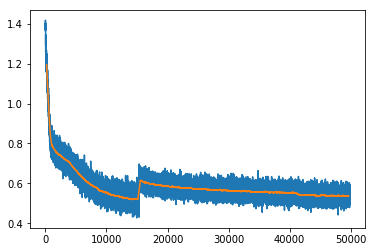

KeyboardInterrupt: 

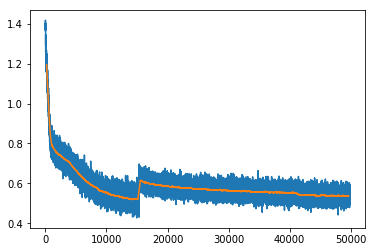

In [64]:
#errs = []

for epoch in range(40000):
    lengths = [4,6,8,16]
    nex = [2,4,6,8,10,20,40]
    
    net.zero_grad()
    err = 0
    count = 0
    
    for LENGTH in lengths:
        for NE in nex:
            data_mx = []
            data_my = []
            data_qx = []
            data_qy = []

            for i in range(40):
                examples, results, queries, labels, rule = mkProblem(N_examples=NE, length=LENGTH)

                data_mx.append(examples)
                data_my.append(results)
                data_qx.append(queries)
                data_qy.append(labels)

            data_mx = np.array(data_mx)
            data_my = np.array(data_my)
            data_qx = np.array(data_qx)
            data_qy = np.array(data_qy)

            mx = tovar(data_mx.reshape((data_mx.shape[0], data_mx.shape[1]*data_mx.shape[2], data_mx.shape[3])))
            qx = tovar(data_qx.reshape((data_qx.shape[0], data_qx.shape[1]*data_qx.shape[2], data_qx.shape[3])))
            my = tovar(data_my.reshape((data_my.shape[0], data_my.shape[1]*data_mx.shape[2], data_my.shape[3])))
            qy = tovar(data_qy.reshape((data_qy.shape[0], data_qy.shape[1]*data_qx.shape[2], data_qy.shape[3])))

            qp = net.forward(mx,my,qx)
            loss = -torch.sum(qp*qy,1).mean()/LENGTH
            loss.backward()
            err = err + loss.cpu().data.numpy()[0]
            count = count+1
    net.adam.step()
    errs.append(err/count)
    plt.clf()
    plt.plot(errs)
    
    cs = np.cumsum(errs)
    plt.plot(np.arange(200,200+cs.shape[0]-400), (cs[400:]-cs[:-400])/400.0)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)
    
    torch.save(net.state_dict(), open("net4.pth","wb"))

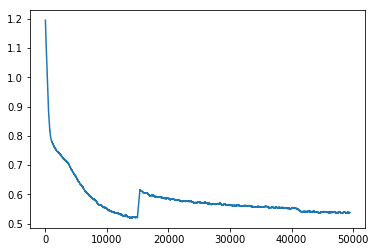

In [74]:
cs = np.cumsum(errs)
cs = (cs[400:]-cs[:-400])/400.0
plt.plot(cs)
plt.show()

In [66]:
cs[-1]

0.537229793073011

In [55]:
for param in net.adam.param_groups:
    param['lr'] = 1e-4

In [67]:
torch.save(net.state_dict(), open("net4.pth","wb"))

In [9]:
def seq2oh(x):
    y = np.zeros((1,4,len(x[0]), len(x)))
    for i in range(len(x)):
        for j in range(len(x[0])):
            y[0,ord(x[i][j])-ord('1'),j,i] = 1
    return y.reshape((1,4*len(x[0]), len(x)))

def getprediction(mx, my, q):
    examples = seq2oh(mx)
    results = seq2oh(my)
    queries = seq2oh(q)
    
    prediction = net.forward(tovar(examples), tovar(results), tovar(queries)).cpu().data.numpy()
    prediction = prediction.reshape((4,examples.shape[1]//4,queries.shape[2]))
    guesses = np.argmax(prediction, axis=0)
    
    results = []
    for i in range(len(q)):
        seq = ''
        for j in range(len(q[0])):
            seq = seq + chr(ord('1') + guesses[j,i])
        results.append(seq)
    
    return results

In [10]:
examples = ['123412', '112242', '132432', '322112', '413242', '222112']
results  = ['214321', '242211', '234231', '211223', '242314', '211222']
queries  = ['211111', '244332', '312212', '411142', '211122', '412142']
correct  = ['111112', '233442', '212213', '241114', '221112', '241214']

predictions = getprediction(examples, results, queries)
print(predictions)
print(correct)

['111112', '233442', '212213', '241114', '221112', '241214']
['111112', '233442', '212213', '241114', '221112', '241214']


In [11]:
examples = ['131442', '233141', '222341', '431122', '343221']
results  = ['311242', '212443', '214333', '332241', '233414']
queries  = ['122334', '223141', '123214']
correct  = ['144332', '212433', '123432']

predictions = getprediction(examples, results, queries)
print(predictions)
print(correct)

['144332', '212433', '123432']
['144332', '212433', '123432']


In [12]:
examples = ['131442', '233141', '222341', '431122', '343221']
results  = ['334324', '323334', '223234', '343322', '432332']
queries  = ['122334', '223141', '123214']
correct  = ['233243', '223334', '232343']

predictions = getprediction(examples, results, queries)
print(predictions)
print(correct)

['234323', '233234', '223333']
['233243', '223334', '232343']


In [13]:
examples = ['131442', '233141', '222341', '431122', '343221']
results  = ['121221', '222121', '221221', '221111', '222111']
queries  = ['122334', '223141', '123214']
correct  = ['121212', '222121', '122112']

predictions = getprediction(examples, results, queries)
print(predictions)
print(correct)

['121222', '222121', '122212']
['121212', '222121', '122112']


In [73]:
examples = ['131442', '233141', '222341', '431122']
results =  ['141113', '214112', '242112', '434131']

queries = ['111111', '121212', '432143']

predictions = getprediction(examples, results, queries)
print(predictions)

['123412', '134231', '431221']


In [ ]:
examples = ['131442', '233141', '222341', '431122']
results =  ['141113', '214112', '242112', '434131']
queries = ['111111', '121212', '432143']

predictions = getprediction(examples, results, queries)
print(predictions)

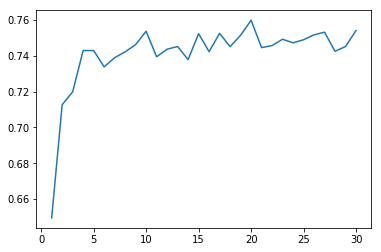

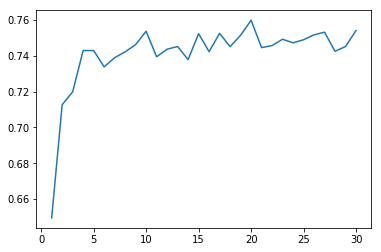

In [61]:
accuracy = []
N_ex = []

for N in range(1,31):
    acc = 0
    for j in range(100):
        data_mx = []
        data_my = []
        data_qx = []
        data_qy = []

        for i in range(40):
            examples, results, queries, labels, rule = mkProblem(N_examples=N, length=8)

            data_mx.append(examples)
            data_my.append(results)
            data_qx.append(queries)
            data_qy.append(labels)

        data_mx = np.array(data_mx)
        data_my = np.array(data_my)
        data_qx = np.array(data_qx)
        data_qy = np.array(data_qy)

        mx = tovar(data_mx.reshape((data_mx.shape[0], data_mx.shape[1]*data_mx.shape[2], data_mx.shape[3])))
        qx = tovar(data_qx.reshape((data_qx.shape[0], data_qx.shape[1]*data_qx.shape[2], data_qx.shape[3])))
        my = tovar(data_my.reshape((data_my.shape[0], data_my.shape[1]*data_mx.shape[2], data_my.shape[3])))
        qy = tovar(data_qy.reshape((data_qy.shape[0], data_qy.shape[1]*data_qx.shape[2], data_qy.shape[3])))

        qp = net.forward(mx,my,qx).cpu().data.numpy().reshape((40,4,8,10))
        
        acc += np.mean(np.argmax(qp,axis=1)==np.argmax(data_qy,axis=1))/100.0
    accuracy.append(acc)
    N_ex.append(N)
    
    plt.clf()
    
    plt.plot(N_ex, accuracy)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

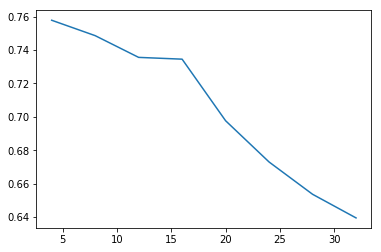

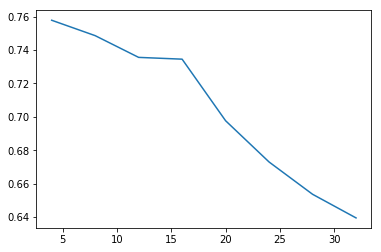

In [62]:
accuracy = []
N_L = []

for N in range(4,33,4):
    acc = 0
    for j in range(100):
        data_mx = []
        data_my = []
        data_qx = []
        data_qy = []

        for i in range(40):
            examples, results, queries, labels, rule = mkProblem(N_examples=10, length=N)

            data_mx.append(examples)
            data_my.append(results)
            data_qx.append(queries)
            data_qy.append(labels)

        data_mx = np.array(data_mx)
        data_my = np.array(data_my)
        data_qx = np.array(data_qx)
        data_qy = np.array(data_qy)

        mx = tovar(data_mx.reshape((data_mx.shape[0], data_mx.shape[1]*data_mx.shape[2], data_mx.shape[3])))
        qx = tovar(data_qx.reshape((data_qx.shape[0], data_qx.shape[1]*data_qx.shape[2], data_qx.shape[3])))
        my = tovar(data_my.reshape((data_my.shape[0], data_my.shape[1]*data_mx.shape[2], data_my.shape[3])))
        qy = tovar(data_qy.reshape((data_qy.shape[0], data_qy.shape[1]*data_qx.shape[2], data_qy.shape[3])))

        qp = net.forward(mx,my,qx).cpu().data.numpy().reshape((40,4,N,10))
        
        acc += np.mean(np.argmax(qp,axis=1)==np.argmax(data_qy,axis=1))/100.0
    accuracy.append(acc)
    N_L.append(N)
    
    plt.clf()
    
    plt.plot(N_L, accuracy)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

In [33]:
data_qy.shape

(40, 4, 8, 10)